In [9]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [10]:
series = read_csv('water.csv', header=0, index_col=0, parse_dates=True)

In [11]:
series

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


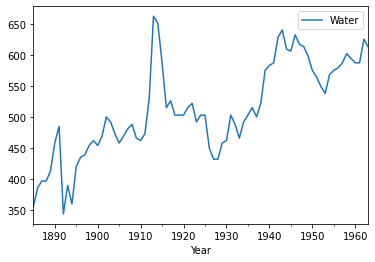

In [12]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

In [13]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


#### Persistence/ Base model

In [14]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]


In [15]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Observed =%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=575.000, Observed =583.000
>Predicted=583.000, Observed =587.000
>Predicted=587.000, Observed =628.000
>Predicted=628.000, Observed =640.000
>Predicted=640.000, Observed =609.000
>Predicted=609.000, Observed =606.000
>Predicted=606.000, Observed =632.000
>Predicted=632.000, Observed =617.000
>Predicted=617.000, Observed =613.000
>Predicted=613.000, Observed =598.000
>Predicted=598.000, Observed =575.000
>Predicted=575.000, Observed =564.000
>Predicted=564.000, Observed =549.000
>Predicted=549.000, Observed =538.000
RMSE: 18.923


#### ARIMA Hyperparameters

In [16]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [21]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e :
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [27]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=111.636
ARIMA(0, 0, 1) RMSE=65.749
ARIMA(0, 0, 2) RMSE=46.411
ARIMA(0, 0, 3) RMSE=39.881
ARIMA(0, 0, 4) RMSE=97.912
ARIMA(0, 1, 0) RMSE=19.829
ARIMA(0, 1, 1) RMSE=19.648
ARIMA(0, 1, 2) RMSE=20.940
ARIMA(0, 1, 3) RMSE=25.635
ARIMA(0, 1, 4) RMSE=25.933
ARIMA(0, 2, 0) RMSE=26.789
ARIMA(0, 2, 1) RMSE=19.461
ARIMA(0, 2, 2) RMSE=19.217
ARIMA(0, 2, 3) RMSE=19.775
ARIMA(0, 2, 4) RMSE=25.225
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0) RMSE=22.978
ARIMA(1, 0, 1) RMSE=23.368
ARIMA(1, 0, 2) RMSE=25.322
ARIMA(1, 0, 3) RMSE=32.954
ARIMA(1, 0, 4) RMSE=32.951
ARIMA(1, 1, 0) RMSE=19.684
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are no

#### Build Model based on the optimized values

In [8]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [20]:
# load data
train = read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [21]:
train

,356
1885-01-01,
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
1890-01-01,458
...,...
1949-01-01,598
1950-01-01,575
1951-01-01,564


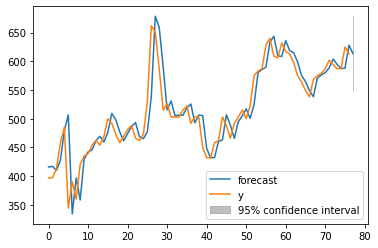

In [32]:
# fit model
model = ARIMA(X, order=(0, 2, 2))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(2, 79)
plt.show()

In [27]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

37.72598063564499

#### Combine train and test data and build final model

In [33]:
# fit model
data = read_csv('water.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = data.values
X = X.astype('float32')

In [34]:
model = ARIMA(X, order=(0, 2, 2))
model_fit = model.fit()

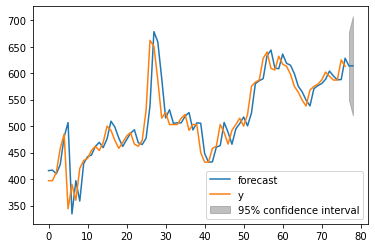

In [36]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(2,80)
plt.show()

In [38]:
forecast

array([611.8022491 , 616.60049738, 620.37840432, 623.44635426,
       626.60594013, 629.84862504, 633.0837188 , 636.3091895 ,
       639.5351986 , 642.76231082])